In [32]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from keras_tuner import HyperModel
from keras_tuner.tuners import RandomSearch, Hyperband 

In [3]:
batch_size = 16
img_height = 100
img_width = 100
data_dir = 'dataset_v3'
confidence_threshold = 0.5
num_classes = 3
epochs = 100

# 1. Wczytanie danych i preprocessing

## 1.1 Wczytanie zdjęć z katalogów


In [31]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.25,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True
)

Found 8473 files belonging to 3 classes.
Using 6355 files for training.


In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.25,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True
)

Found 8473 files belonging to 3 classes.
Using 2118 files for validation.


In [6]:
class_names = train_ds.class_names
print(class_names)

['BCC', 'MEL', 'SCC']


### Przykłady obrazów

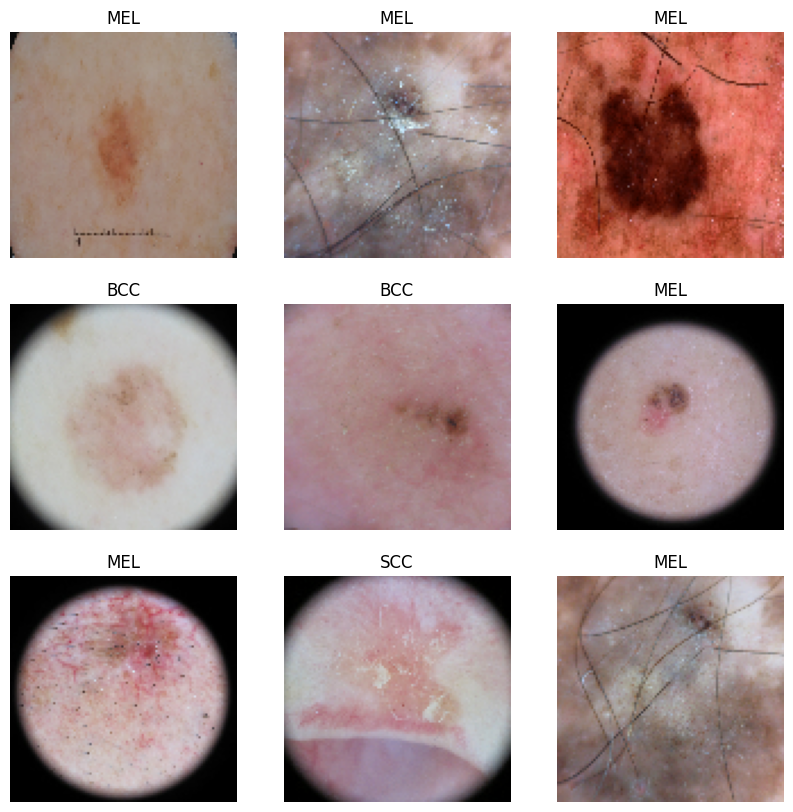

In [30]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Dodatkowe wymieszanie zdjęć w zbiorach i augmentacja

In [7]:
def augment_image(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    return image

In [8]:
def augment_data(images, labels):
    augmented_images = []
    for image in images:
        augmented_image = augment_image(image)
        augmented_images.append(augmented_image.numpy())
    return np.array(augmented_images), labels

In [9]:
def shuffle_data(x, y):
    indices = np.arange(x.shape[0])
    np.random.shuffle(indices)
    return x[indices], y[indices]

In [10]:
def dataset_to_numpy(ds):
    images = []
    labels = []
    for image, label in ds:
        images.append(image.numpy())
        labels.append(label.numpy())
    images = np.concatenate(images)
    labels = np.concatenate(labels)
    images, labels = shuffle_data(images, labels)
    return augment_data(images, labels)

In [11]:
x_train, y_train = dataset_to_numpy(train_ds)
x_val, y_val = dataset_to_numpy(val_ds)

### Obliczenie wag

In [12]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

# 2. Definicja modelu

In [13]:
class MyModel(HyperModel):
    def build(self, hp):
        base_model = tf.keras.applications.DenseNet121(
            input_shape=(img_height, img_width, 3),
            include_top=False,
            weights='imagenet'
        )

        base_model.trainable = True
        fine_tune_at = hp.Int('fine_tune_at', min_value=50, max_value=250, step=25)

        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable = False

        model = tf.keras.Sequential([
            base_model,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(
                units=hp.Int('units', min_value=512, max_value=2048, step=256),
                activation='relu',
                kernel_regularizer=tf.keras.regularizers.l2(0.01)
            ),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(num_classes, activation='softmax')
        ])
        
        learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5, 1e-6]),
            decay_steps=100000,
            decay_rate=0.96,
            staircase=True
        )

        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_schedule),
            loss=tf.losses.SparseCategoricalCrossentropy(),
            metrics=['accuracy']
        )
        return model

In [14]:
hypermodel = MyModel()

## 2.2 Tuning (Hiperparamteryzacja) oraz definicja callbacków

In [15]:
tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='tuner',
    project_name='my_model_tuning'
)

Reloading Tuner from tuner/my_model_tuning/tuner0.json


In [16]:
tuner.search_space_summary()

Search space summary
Default search space size: 3
fine_tune_at (Int)
{'default': None, 'conditions': [], 'min_value': 50, 'max_value': 250, 'step': 25, 'sampling': 'linear'}
units (Int)
{'default': None, 'conditions': [], 'min_value': 512, 'max_value': 2048, 'step': 256, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001, 1e-05, 1e-06], 'ordered': True}


In [17]:
callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7),
    tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)
]

In [18]:
tuner.search(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs, callbacks=callbacks, class_weight=class_weights)

Trial 10 Complete [00h 06m 20s]
val_accuracy: 0.7497639060020447

Best val_accuracy So Far: 0.8881019949913025
Total elapsed time: 02h 39m 55s


In [19]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [20]:
model = tuner.hypermodel.build(best_hps)

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 3, 3, 1024)        7037504   
                                                                 
 global_average_pooling2d_1  (None, 1024)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_4 (Dense)             (None, 1024)              1049600   
                                                                 
 batch_normalization_3 (Bat  (None, 1024)              4096      
 chNormalization)                                                
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 512)              

In [25]:
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=epochs,
    callbacks=callbacks,
    class_weight=class_weights
)

Epoch 1/100
199/199 [==============================] - 16s 78ms/step - loss: 0.1789 - accuracy: 0.9740 - val_loss: 0.6596 - val_accuracy: 0.8683 - lr: 1.0000e-04
Epoch 2/100
199/199 [==============================] - 15s 78ms/step - loss: 0.1881 - accuracy: 0.9681 - val_loss: 0.6237 - val_accuracy: 0.8532 - lr: 1.0000e-04
Epoch 3/100
199/199 [==============================] - 15s 77ms/step - loss: 0.1356 - accuracy: 0.9830 - val_loss: 0.6135 - val_accuracy: 0.8725 - lr: 1.0000e-04
Epoch 4/100
199/199 [==============================] - 15s 75ms/step - loss: 0.1343 - accuracy: 0.9846 - val_loss: 0.7612 - val_accuracy: 0.8404 - lr: 1.0000e-04
Epoch 5/100
199/199 [==============================] - 15s 75ms/step - loss: 0.1256 - accuracy: 0.9868 - val_loss: 0.6310 - val_accuracy: 0.8588 - lr: 1.0000e-04
Epoch 6/100
199/199 [==============================] - ETA: 0s - loss: 0.1719 - accuracy: 0.9734

/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


199/199 [==============================] - 16s 80ms/step - loss: 0.1719 - accuracy: 0.9734 - val_loss: 0.5468 - val_accuracy: 0.8754 - lr: 1.0000e-04
Epoch 7/100
199/199 [==============================] - 15s 74ms/step - loss: 0.1025 - accuracy: 0.9888 - val_loss: 0.5904 - val_accuracy: 0.8730 - lr: 1.0000e-04
Epoch 8/100
199/199 [==============================] - 16s 79ms/step - loss: 0.0916 - accuracy: 0.9910 - val_loss: 0.5327 - val_accuracy: 0.8820 - lr: 1.0000e-04
Epoch 9/100
199/199 [==============================] - 15s 77ms/step - loss: 0.0623 - accuracy: 0.9962 - val_loss: 0.5962 - val_accuracy: 0.8744 - lr: 1.0000e-04
Epoch 10/100
199/199 [==============================] - 15s 75ms/step - loss: 0.0741 - accuracy: 0.9928 - val_loss: 1.1377 - val_accuracy: 0.8536 - lr: 1.0000e-04
Epoch 11/100
199/199 [==============================] - 15s 75ms/step - loss: 0.1831 - accuracy: 0.9660 - val_loss: 0.6555 - val_accuracy: 0.8414 - lr: 1.0000e-04
Epoch 12/100
199/199 [================

In [26]:
model.save('new_best.keras')

67/67 [==============================] - 1s 21ms/step


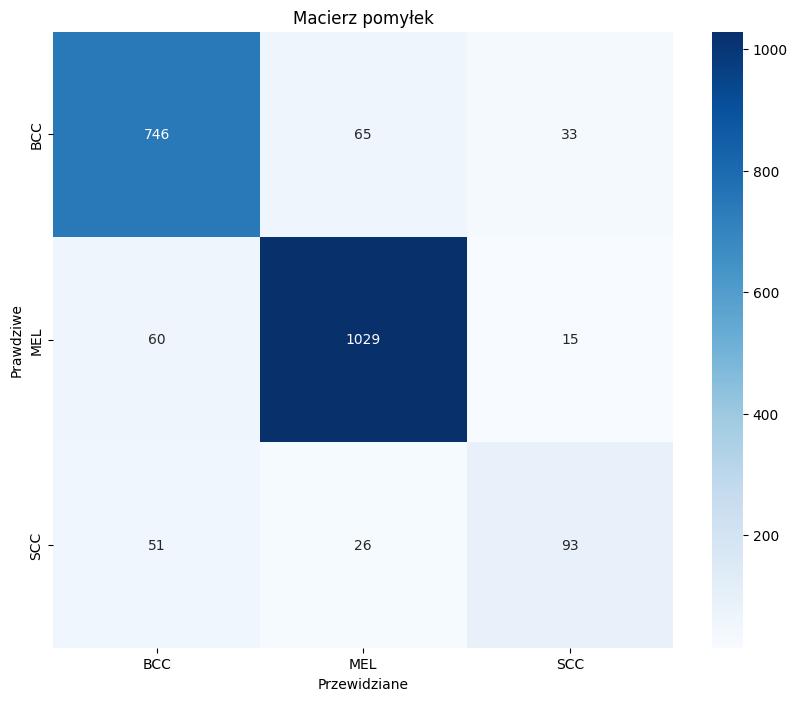

              precision    recall  f1-score   support

         BCC       0.87      0.88      0.88       844
         MEL       0.92      0.93      0.93      1104
         SCC       0.66      0.55      0.60       170

    accuracy                           0.88      2118
   macro avg       0.82      0.79      0.80      2118
weighted avg       0.88      0.88      0.88      2118



In [29]:
y_pred = np.argmax(model.predict(x_val), axis=-1)

cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_ds.class_names, yticklabels=train_ds.class_names)
plt.xlabel('Przewidziane')
plt.ylabel('Prawdziwe')
plt.title('Macierz pomyłek')
plt.show()

print(classification_report(y_val, y_pred, target_names=train_ds.class_names))